# UNET AutoEncoder for Cifar dataset

## Backend and Import

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

import os
import pickle
import numpy as np
import cv2

Using TensorFlow backend.


## Load Cifar10 dataset

In [3]:
batch_size = 50
num_classes = 10
epochs = 100
saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]

In [8]:
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


## dice coefficient loss function

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

## UNET AutoEncoder

In [10]:
inputs = Input((32, 32, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

In [11]:
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

In [12]:
model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])

## Train AutoEncoder

In [13]:
# load pretrained weights
model.load_weights(os.path.join(saveDir,"AutoEncoder_UNET_weights.00--0.71--0.72.hdf5"))

In [14]:
es_cb = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_UNET_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [15]:
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 50000 samples, validate on 7000 samples
Epoch 1/100
17800/50000 [=========>....................] - ETA: 2881s - loss: -0.7156 - dice_coef: 0.7156

KeyboardInterrupt: 

## Evaluate with test dataset

In [15]:
score = model.evaluate(x_test, x_test, verbose=1)
print(score)

3000/3000 [==============================] - 71s    
[-0.71480361763636269, 0.71480361636479695]


## Visualize original image, semantic segmentation, and gray-scale and RGB histogram

In [16]:
c10test = model.predict(x_test)
c10val = model.predict(x_val)

In [17]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

Cifar10_test: 0.6481792330741882
Cifar10_val: 0.6543164253234863


In [33]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 8))

    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display histogram
        ax = plt.subplot(4, n, i +1 + n + n)
        plt.hist((orig[i]*255).ravel(),256,[0,256])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        
        ax = plt.subplot(4, n, i +1 + n + n + n)
        color = ('b','g','r')
        for j,col in enumerate(color):
            histr = cv2.calcHist([(orig[i]*255)],[j],None,[256],[0,256])
            plt.plot(histr,color = col)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
    plt.show()

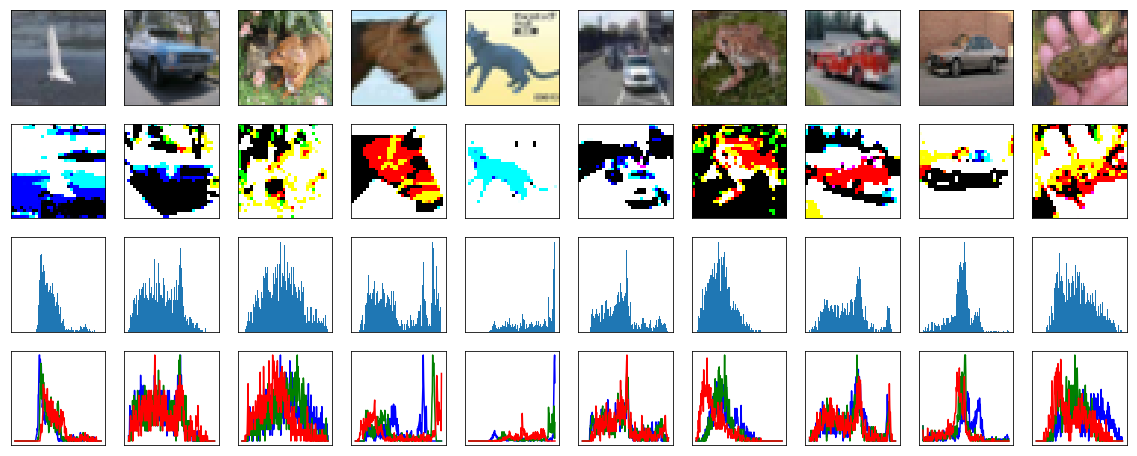

In [34]:
showOrigDec(x_test, c10test)

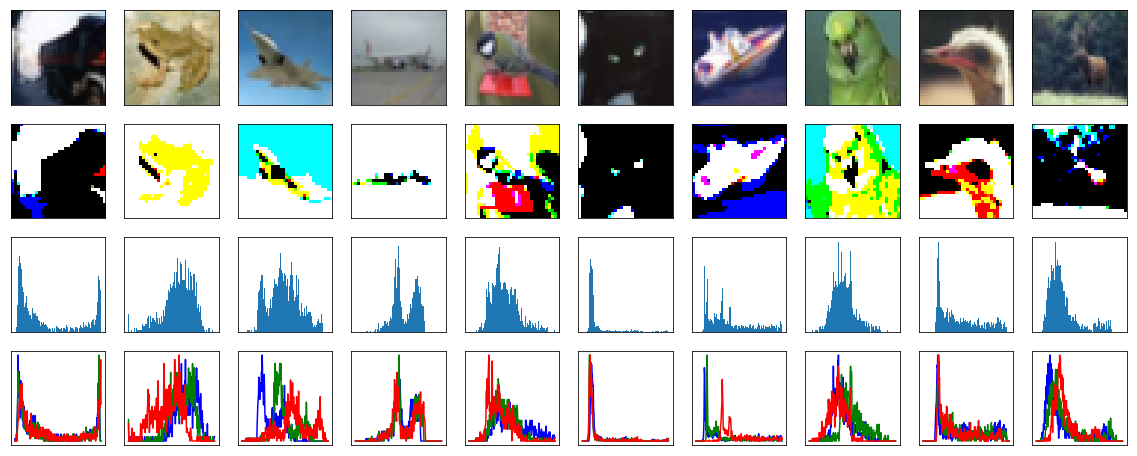

In [35]:
showOrigDec(x_test[100:], c10test[100:])

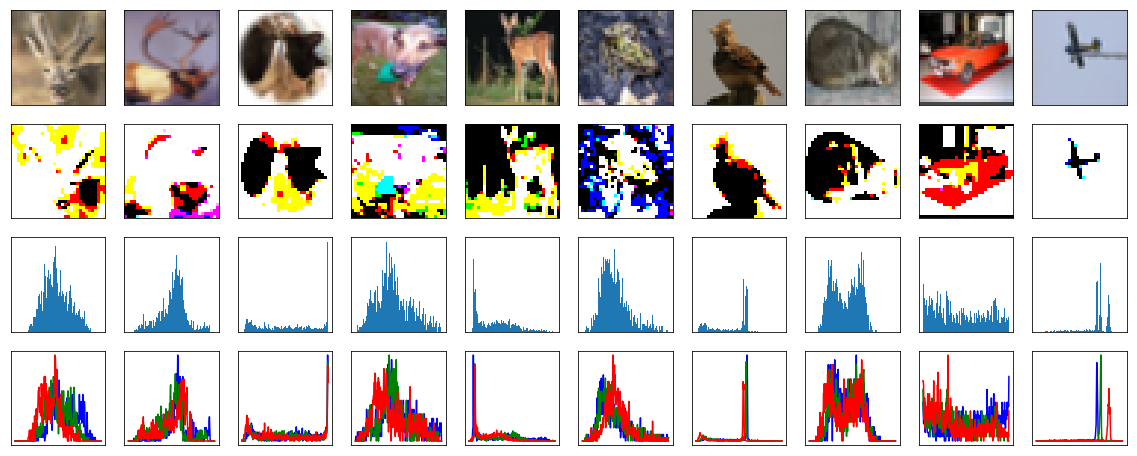

In [36]:
showOrigDec(x_test[200:], c10test[200:])

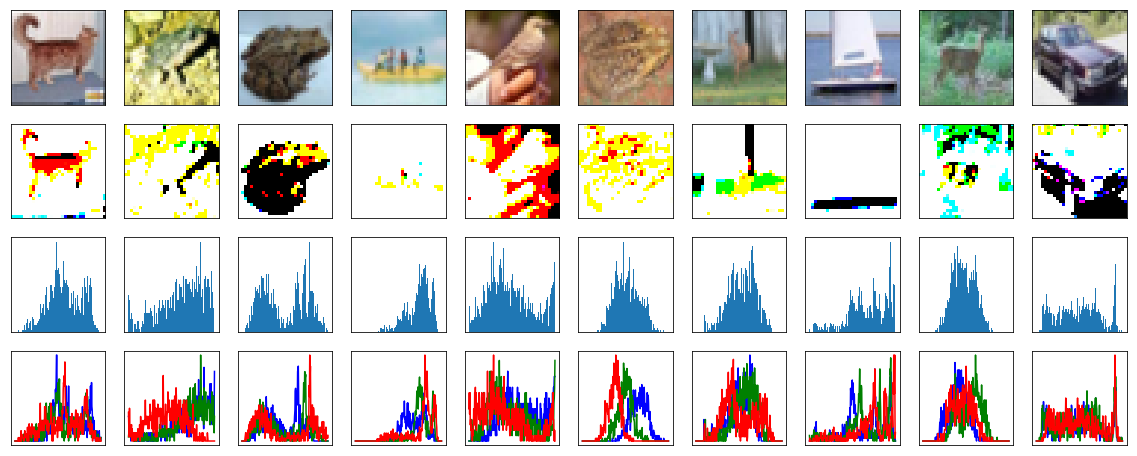

In [37]:
showOrigDec(x_test[300:], c10test[300:])

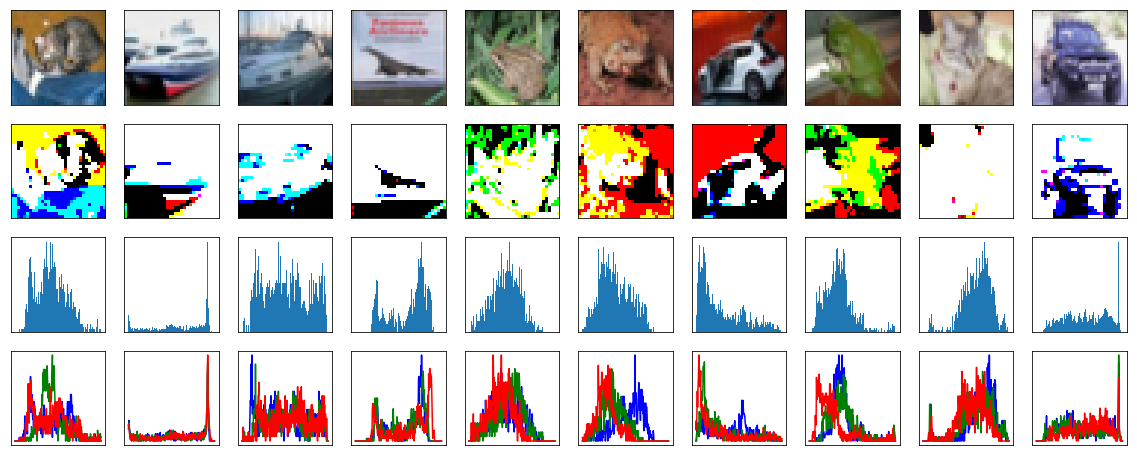

In [38]:
showOrigDec(x_val, c10val)

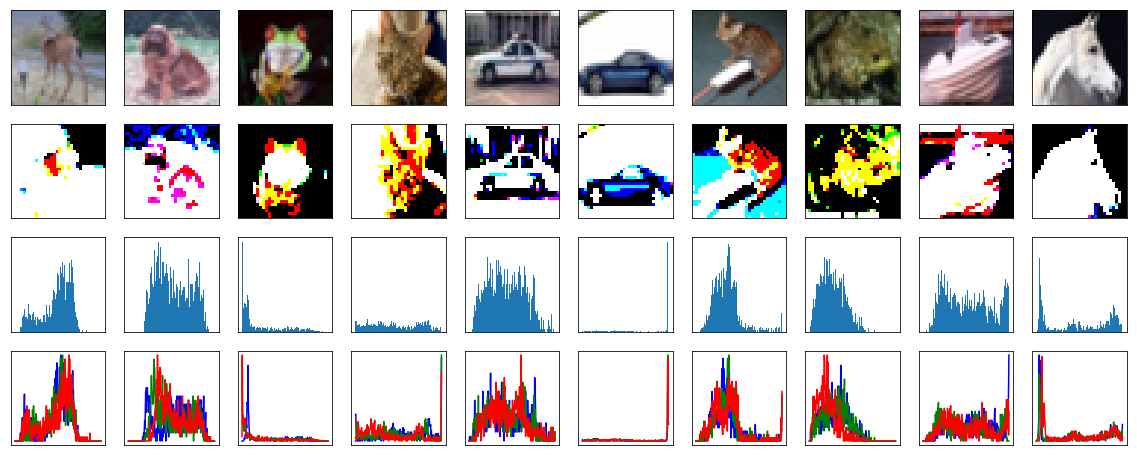

In [39]:
showOrigDec(x_val[100:], c10val[100:])

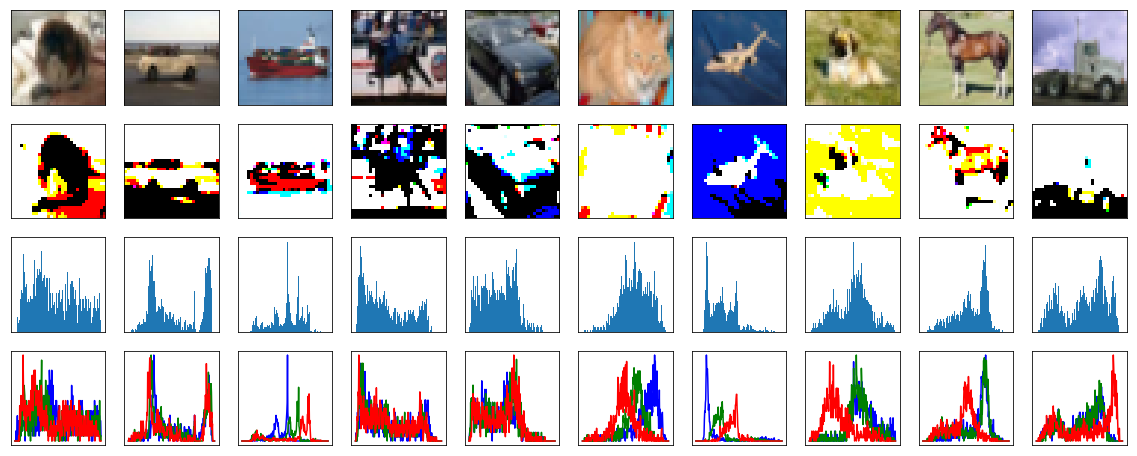

In [40]:
showOrigDec(x_val[200:], c10val[200:])

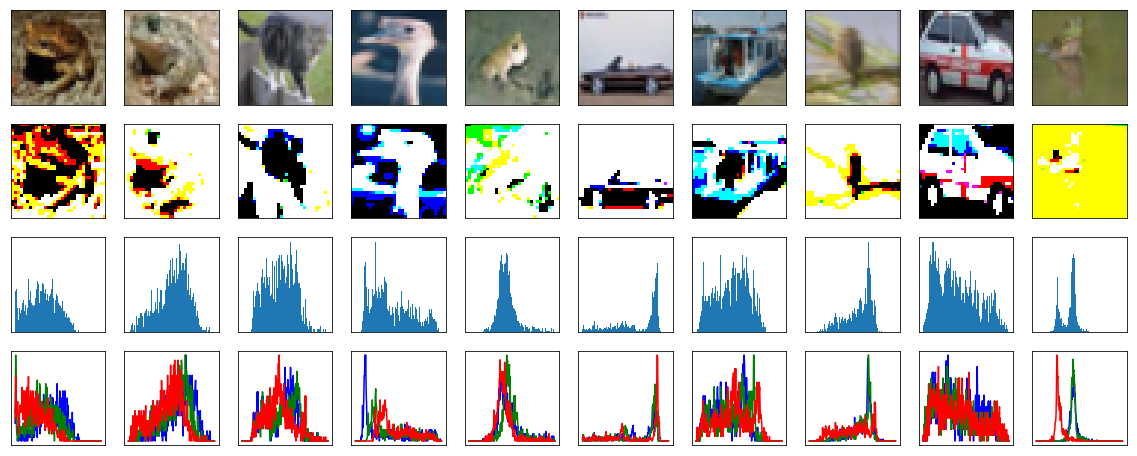

In [41]:
showOrigDec(x_val[300:], c10val[300:])

## Try the UNET AutoEncoder on Cifar100

## Load cifar100 dataset

In [42]:
from keras.datasets import cifar100

(x_train100, y_train100), (x_test100, y_test100) = cifar100.load_data()

In [43]:
# normalize data
x_train100 = x_train100.astype('float32')
x_test100 = x_test100.astype('float32')
x_train100 /= 255
x_test100 /= 255

In [44]:
print('x_train100 shape:', x_train100.shape)
print(x_train100.shape[0], 'train samples')
print(x_test100.shape[0], 'test samples')

x_train100 shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [45]:
score = model.evaluate(x_train100, x_train100, verbose=1)
print(score)

50000/50000 [==============================] - 1164s  
[-0.72797376232147215, 0.72797376205444331]


In [46]:
score = model.evaluate(x_test100, x_test100, verbose=1)
print(score)

10000/10000 [==============================] - 220s   
[-0.72938392457962031, 0.72938392553329467]


## Autoencoder on Cifar100 dateset

In [47]:
c100train = model.predict(x_train100)
c100test = model.predict(x_test100)

In [48]:
print("Cifar100 train: {0} \nCifar100 test: {1}"
      .format(np.average(c100train), np.average(c100test)))

Cifar100 train: 0.638134241104126 
Cifar100 test: 0.6383699178695679


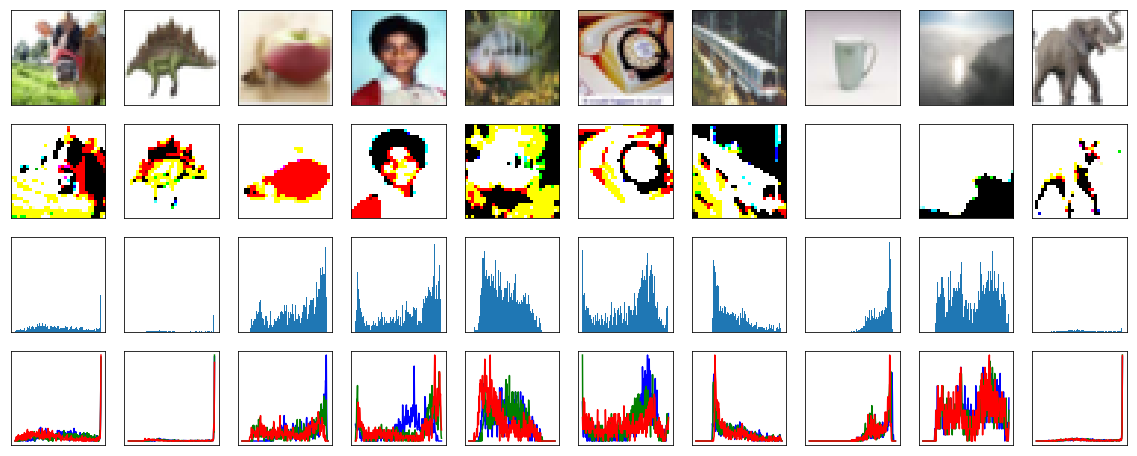

In [49]:
showOrigDec(x_train100, c100train)

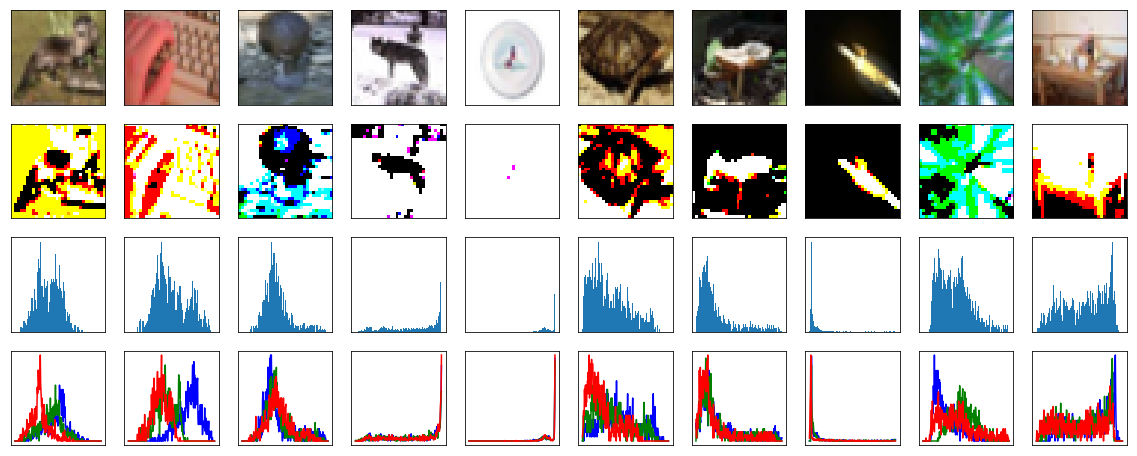

In [50]:
showOrigDec(x_train100[100:], c100train[100:])

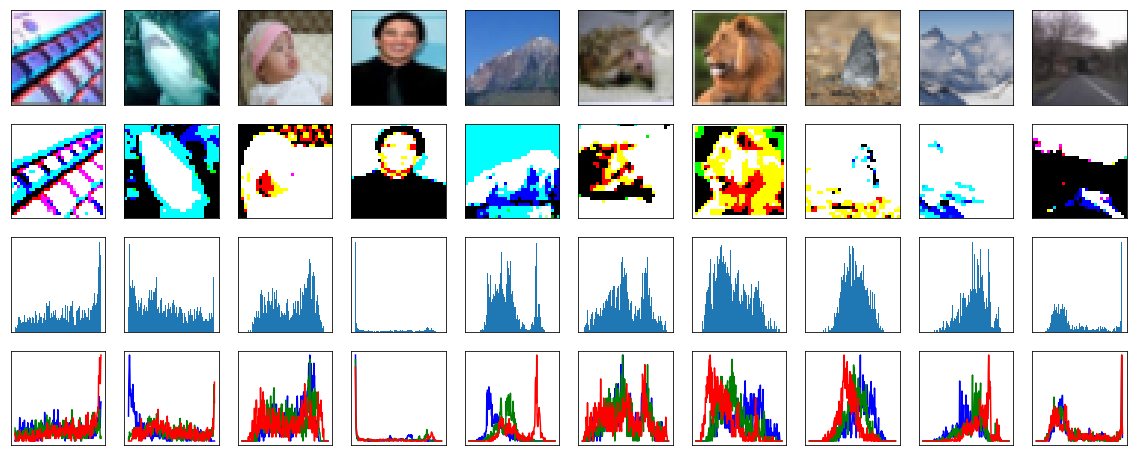

In [51]:
showOrigDec(x_train100[200:], c100train[200:])

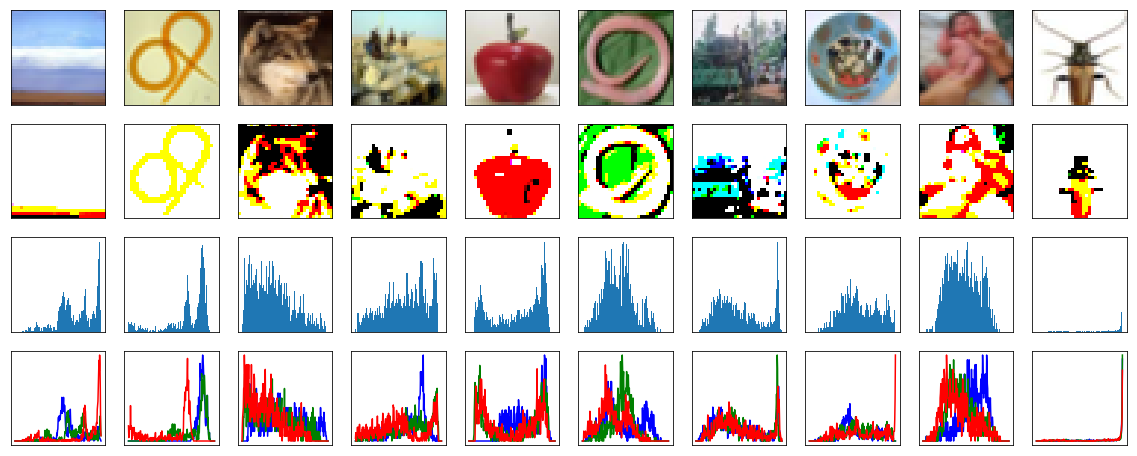

In [52]:
showOrigDec(x_train100[300:], c100train[300:])

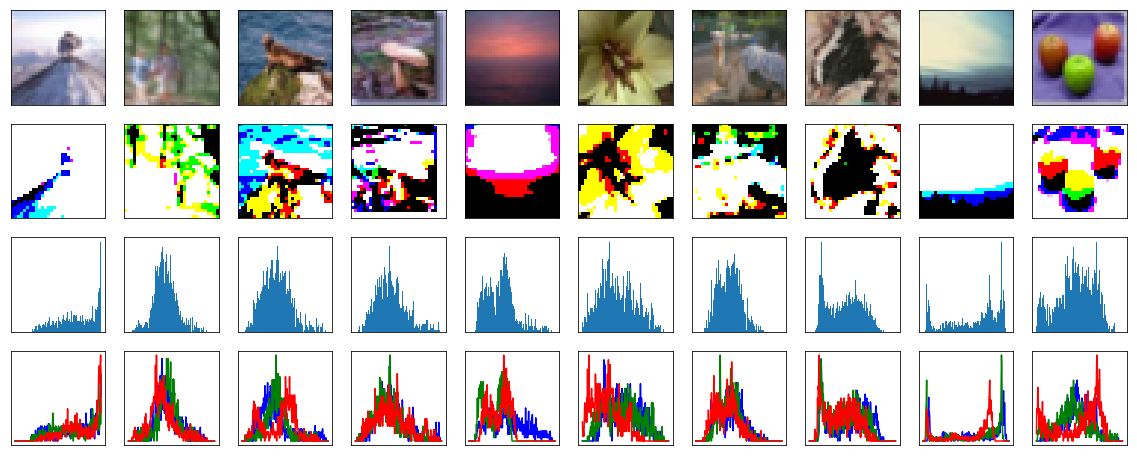

In [53]:
showOrigDec(x_test100, c100test)

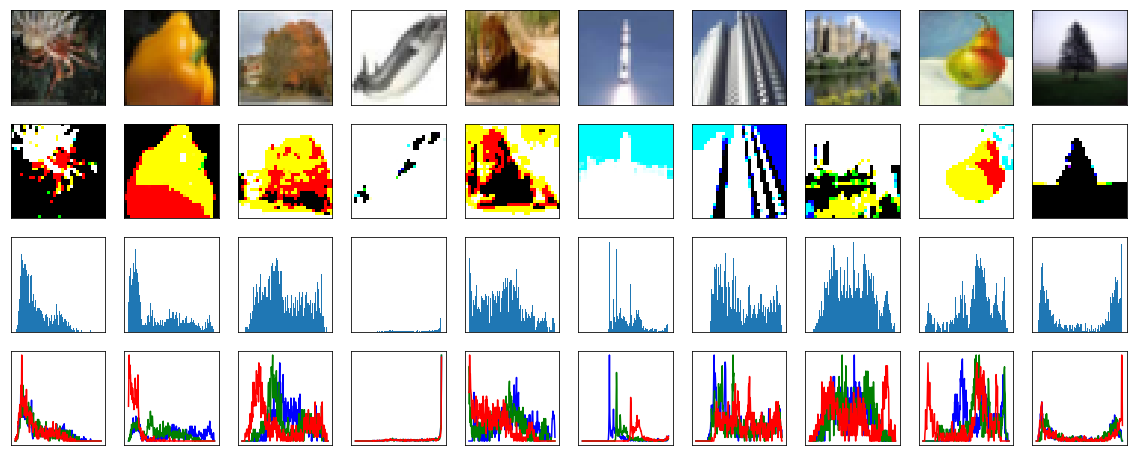

In [54]:
showOrigDec(x_test100[100:], c100test[100:])

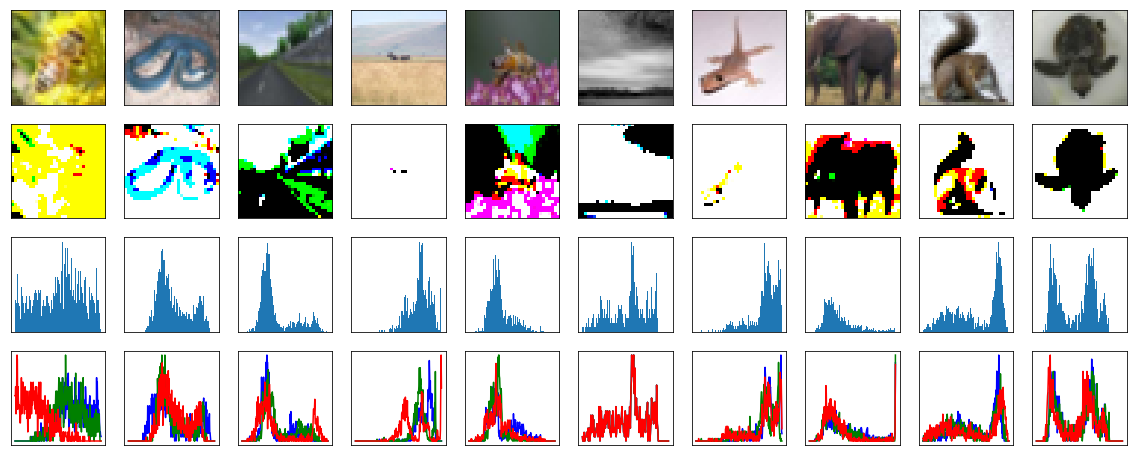

In [55]:
showOrigDec(x_test100[200:], c100test[200:])

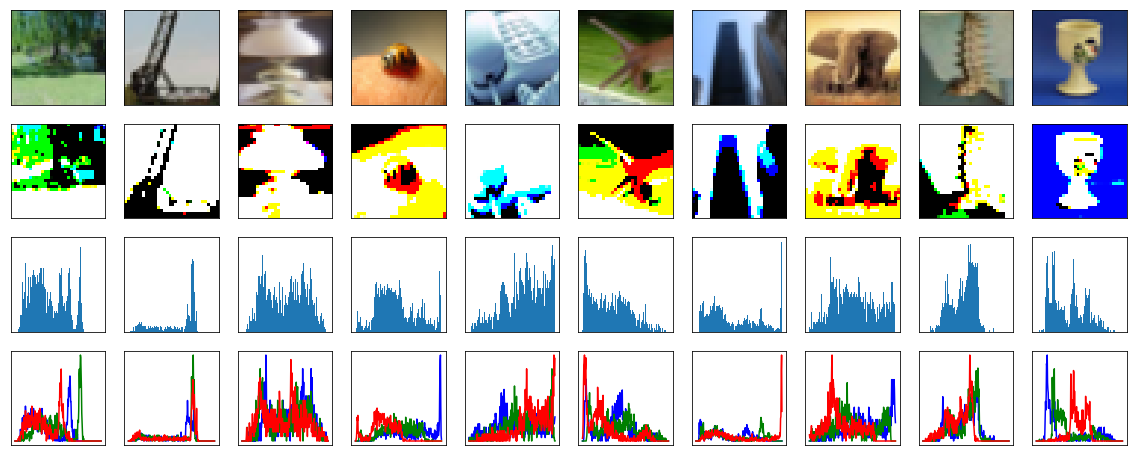

In [56]:
showOrigDec(x_test100[300:], c100test[300:])